In [1]:
import os
import pickle
import numpy as np
from random import shuffle
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import MultipleLocator
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from utils import *
from qs_vae import *
from utils_features import *
from tqdm import tqdm

### Content  
In this notebook, we take the most successful fold (44) and train an ***ensemble*** of 50 different models with the same ConvNet architecture over 100 epochs each. The optimal model parameters for each run are then saved. The models will be used in concert in the future to derive an average score and map for any explanation. This ensemble method is primarily to overcome the ***Frozen in*** and ***degenerate minima*** problem noticed when applying Grad-Cam to artificial data beset with simple artifacts. For a full explanation of these effects see notebook ***Ensemble_Artifact_Test.ipynb***.

In [2]:
class CNN(nn.Module):
    '''
    ConvNet architecture for Grad-CAM application
    '''
    def __init__(self, num_classes=2):
        super(CNN, self).__init__()
        self.num_classes = num_classes
        
        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=2, kernel_size=20, stride=3),
            nn.ReLU(),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=10, stride=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=44, out_features=5),
            nn.ReLU(),
            nn.Linear(in_features=5, out_features=self.num_classes)
        )
        
    def forward(self,x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        return self.linear_layers(x)

#### Functions for training the models

In [3]:
def train():
    '''
    training loop for the model
    output --> average loss on the training dataset after each epoch  
    '''
    model.train()
    train_loss = []
    for x, y in train_dataloader:
        x = x.view(-1, 1, x.shape[-1]).to(device)
        y = y.long().to(device)
        optimizer.zero_grad()
        y_hat = model(x)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    train_loss = np.array(train_loss)
    train_loss = np.mean(train_loss)
        
    return train_loss

def test():
    '''
    Test loop for the model
    output --> average loss on the test dataset after each epoch  
    '''
    model.eval()
    val_loss = []
    for x, y in test_dataloader:
        x = x.view(-1, 1, x.shape[-1]).to(device)
        y = y.long().to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)
        val_loss.append(loss.item())
    val_loss = np.array(val_loss)
    val_loss = np.mean(val_loss)
        
    return val_loss

def calculate_metrics(loader, model):
    '''
    Calculates the true skill statistic and accuracy 
    '''
    num_correct = 0
    num_samples = 0
    matrix = np.zeros((2,2))
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.view(-1, 1, x.shape[-1]).to(device)
            y = y.long().to(device)
            y_hat = model(x)
            _, predicted_class = y_hat.max(dim=1)
            num_correct += (predicted_class == y).sum()
            num_samples += predicted_class.size(0)
            acc = np.round(float(num_correct)/float(num_samples)*100,2)
            matrix += confusion_matrix(y.cpu(), predicted_class.cpu())
    TP = matrix[0,0]
    FP = matrix[0,1]
    FN = matrix[1,0]
    TN = matrix[1,1]
    TSS = np.round(TP/(TP+FN) - FP/(FP+TN),2)
    return TSS, acc

class ConvNetDataSet(Dataset):
    '''
    DataLoader
    '''
    def __init__(self, partition='train'):
        fhand = np.load(f'/data1/userspace/bpanos/XAI/data/ensembl/{fold}/{partition}.npz')
        self.X = torch.Tensor(fhand['X'])
        self.y = torch.Tensor(fhand['y'])
        
    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self, index):
        return self.X[index,:], self.y[index]

### Split 44

In [4]:
fold = 44

#### Create train and test dataset based on the observations of the current selected fold

In [5]:
with open(f'/data1/userspace/bpanos/XAI/models/ConvNet/{fold}.p', 'rb') as f: dic = pickle.load(f)
path_to_clean_data = '/data1/userspace/bpanos/XAI/data/ConvNet/clean_strong/'
train_obs = dic['train_obs']
AR_train = []
PF_train = []
for n in train_obs:
    if 'AR' in n:
        AR_train.append(n)
    if 'PF' in n:
        PF_train.append(n)
    
tets_obs = dic['test_obs']
AR_test = []
PF_test = []
for n in tets_obs:
    if 'AR' in n:
        AR_test.append(n)
    if 'PF' in n:
        PF_test.append(n)
        
def Balance(X1, X2):
    '''
    Takes in two numpy arrays and under samples the larger array to have a 1:1 ratio
    '''
    if len(X1) < len(X2):
        rand_int = np.random.choice(len(X2), len(X1), replace=False)
        X2 = X2[rand_int, :]
    if len(X2) < len(X1):
        rand_int = np.random.choice(len(X1), len(X2), replace=False)
        X1 = X1[rand_int, :]
    return X1, X2

X_train_AR = None
X_train_PF = None
for AR_file, PF_file in zip(AR_train, PF_train):

    fhand = np.load(path_to_clean_data + AR_file)
    X_AR = fhand['X']
    try: X_train_AR = np.concatenate( (X_train_AR, X_AR), axis=0 )
    except: X_train_AR = X_AR

    fhand = np.load(path_to_clean_data + PF_file)
    X_PF = fhand['X']
    try: X_train_PF = np.concatenate( (X_train_PF, X_PF), axis=0 )
    except: X_train_PF = X_PF

X_train_AR, X_train_PF = Balance(X_train_AR, X_train_PF)
y_train_AR = np.zeros(len(X_train_AR))
y_train_PF = np.ones(len(X_train_PF))

X_train = np.concatenate((X_train_AR, X_train_PF), axis=0)
y_train = np.concatenate((y_train_AR, y_train_PF))

X_test_AR = None
X_test_PF = None
for AR_file, PF_file in zip(AR_test, PF_test):

    fhand = np.load(path_to_clean_data + AR_file)
    X_AR = fhand['X']
    try: X_test_AR = np.concatenate( (X_test_AR, X_AR), axis=0 )
    except: X_test_AR = X_AR

    fhand = np.load(path_to_clean_data + PF_file)
    X_PF = fhand['X']
    try: X_test_PF = np.concatenate( (X_test_PF, X_PF), axis=0 )
    except: X_test_PF = X_PF

X_test_AR, X_test_PF = Balance(X_test_AR, X_test_PF)
y_test_AR = np.zeros(len(X_test_AR))
y_test_PF = np.ones(len(X_test_PF))

X_test = np.concatenate((X_test_AR, X_test_PF), axis=0)
y_test = np.concatenate((y_test_AR, y_test_PF))

# undersample test set to 40 percent
n_test = int(len(X_train) * 0.4)
try:
    rand_ind = np.random.choice(len(X_test)-3, n_test, replace=False)
    X_test = X_test[rand_ind,:]
    y_test = y_test[rand_ind]
except Exception: pass

In [29]:
np.savez(f'/data1/userspace/bpanos/XAI/data/ensembl/{fold}/train', X=X_train, y=y_train)
np.savez(f'/data1/userspace/bpanos/XAI/data/ensembl/{fold}/test', X=X_test, y=y_test)

#### Train 50 models  100 epoch each
We select the best performing split of train and test data, i.e., fold 44 and save three models per training  
1. The model with the lowest validation loss **_val**  
2. The model with the lowest average loss between the validation and training set ***_av*** 
3. The last model at epoch 100 irrespective of the loss ***_last*** 

In [35]:
for indd in tqdm(range(50)):

    n_epoch = 100
    model = CNN(num_classes=2).to(device)
    learning_rate = 0.001
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    batch_size = 64
    train_dataset = ConvNetDataSet(partition='train')
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    test_dataset = ConvNetDataSet(partition='test')
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

    save_path_models = f'/data1/userspace/bpanos/XAI/models/ensembl2/{fold}/'
    train_loss_list = []
    validation_loss_list = []
    best_val_loss = 1e9
    best_av_loss = 1e9

    for epoch in range(n_epoch):
        current_train_loss = train()
        train_loss_list.append(current_train_loss)
        current_val_loss = test()
        validation_loss_list.append(current_val_loss)

        # 1) save the model with the lowest validation loss
        if current_val_loss < best_val_loss:
            torch.save(model.state_dict(), f'{save_path_models}{indd}_val.pt')
            best_val_loss = current_val_loss
            best_epoch = epoch
        
        # 2) save the model with the loswest avarage loss between train and validation 
        carrent_av_loss = (current_val_loss + current_train_loss)/2.
        if carrent_av_loss < best_av_loss:
            torch.save(model.state_dict(), f'{save_path_models}{indd}_av.pt')
            best_av_loss = carrent_av_loss
            best_epoch_av = epoch
        
    # 3) save the last model   
    torch.save(model.state_dict(), f'{save_path_models}{indd}_last.pt')   

    model = CNN(num_classes=2)
    model.load_state_dict(torch.load(f'{save_path_models}{indd}_val.pt'))
    model.to(device)
    model.eval();

    TSS, ACC = calculate_metrics(test_dataloader, model)
    print(f'TSS: {TSS} ACC: {ACC}')

    stats = {'train_obs': AR_train + PF_train,
             'test_obs': AR_test + PF_test,
             'n_train': len(X_train),
             'n_test': len(X_test),
             'epoch': best_epoch,
             'TSS': TSS,
             'ACC': ACC,
             'validation_loss_list': validation_loss_list,
             'train_loss_list': train_loss_list,
             'best_epoch_av':best_epoch_av}

    with open(f'{save_path_models}{indd}.p', 'wb') as f: pickle.dump(stats,f)

    del model, train_dataloader, train_dataset, test_dataloader, test_dataset

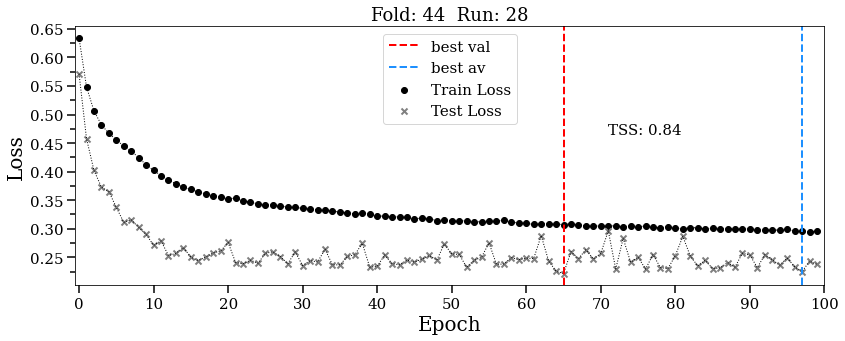

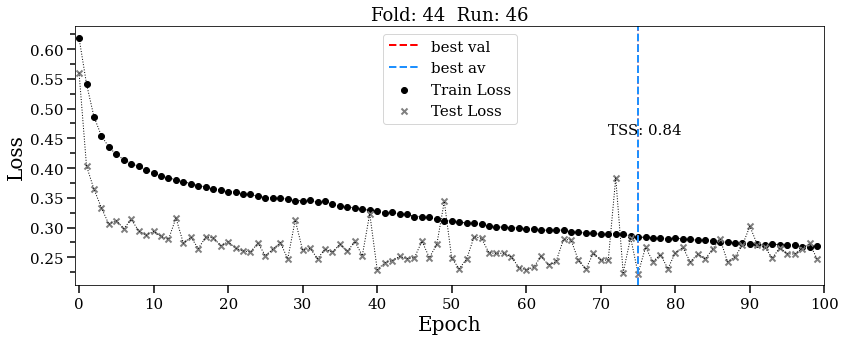

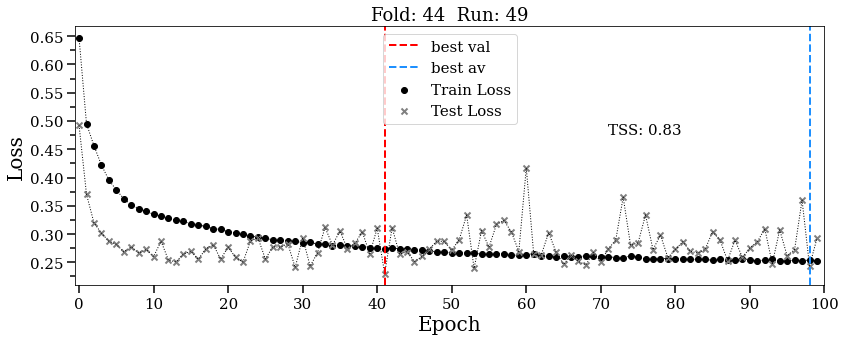

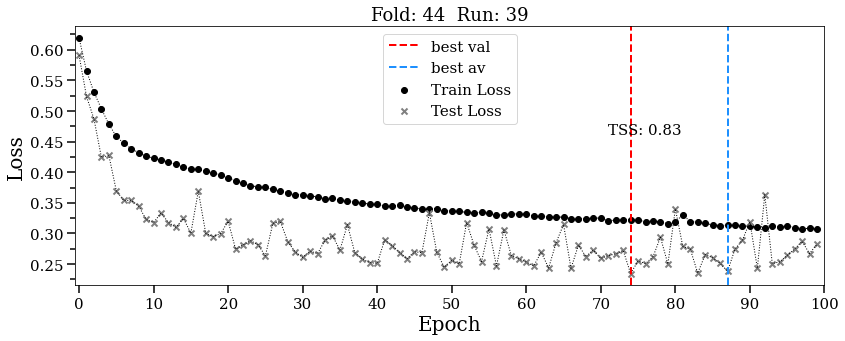

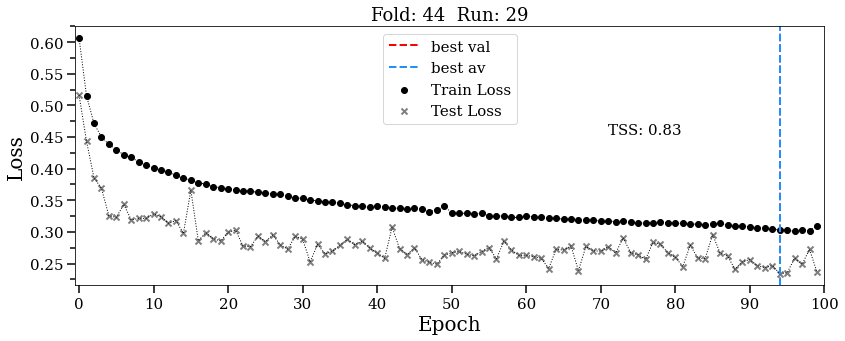

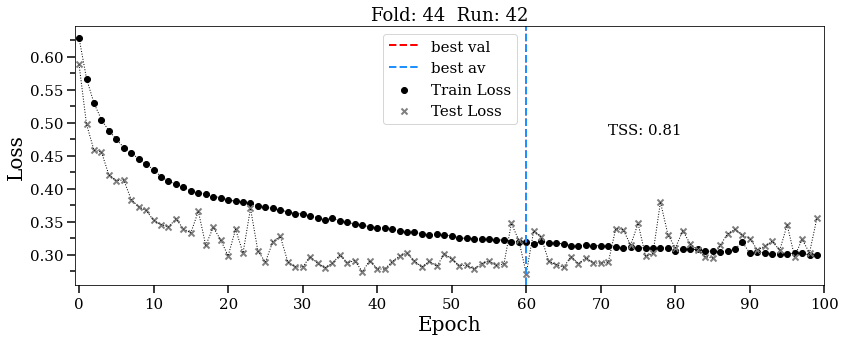

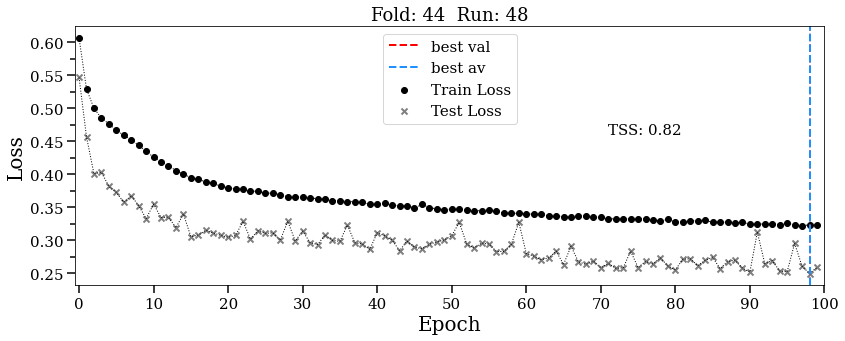

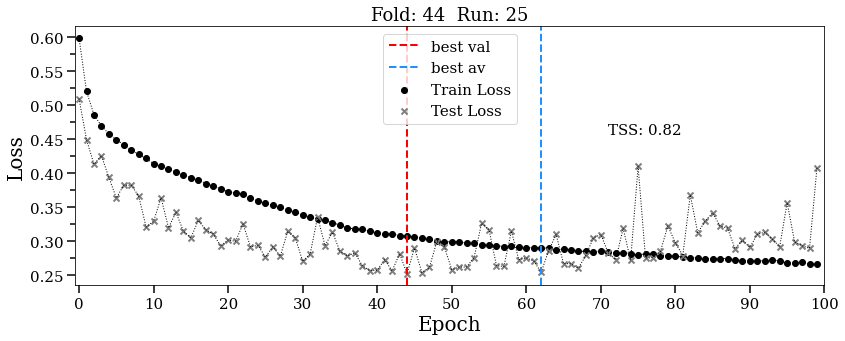

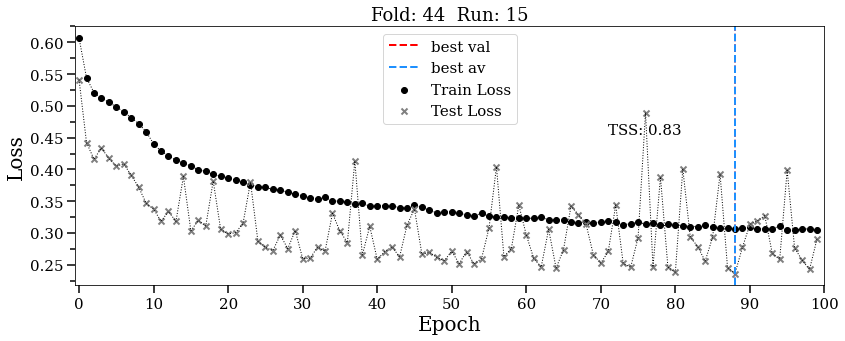

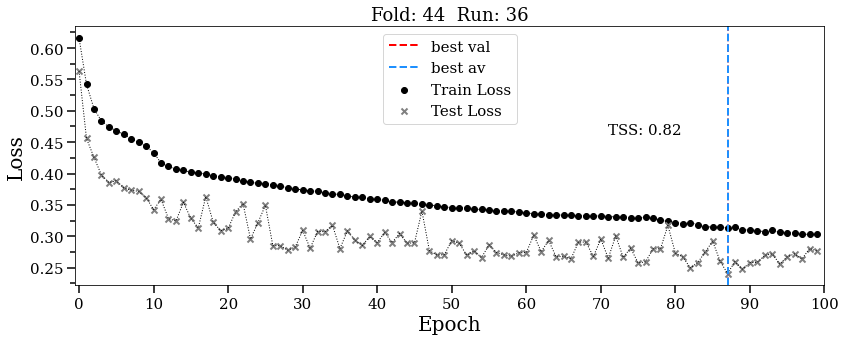

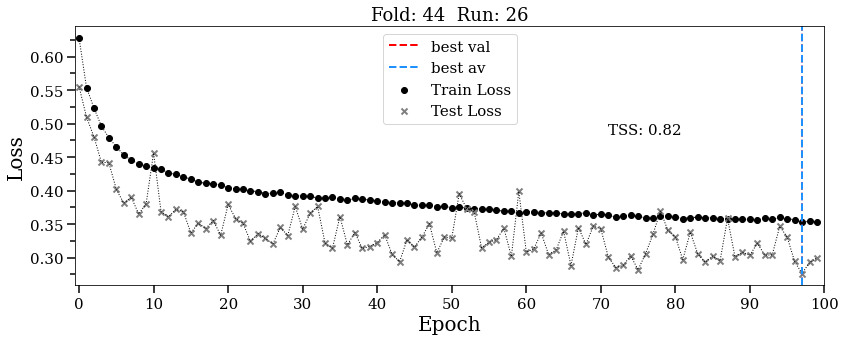

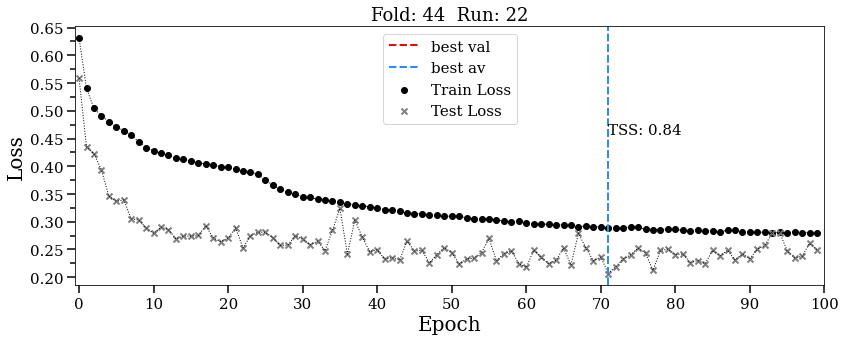

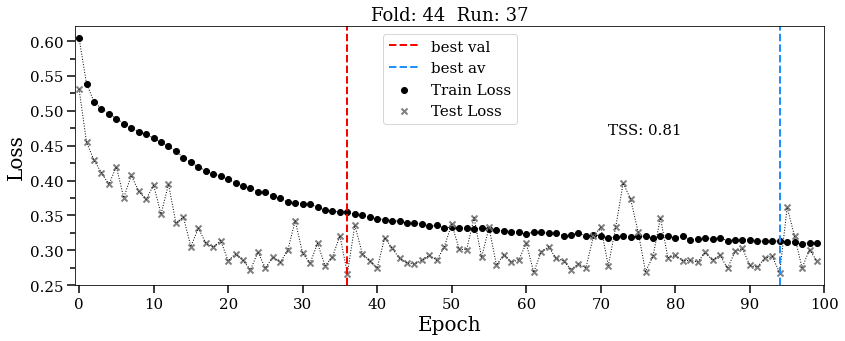

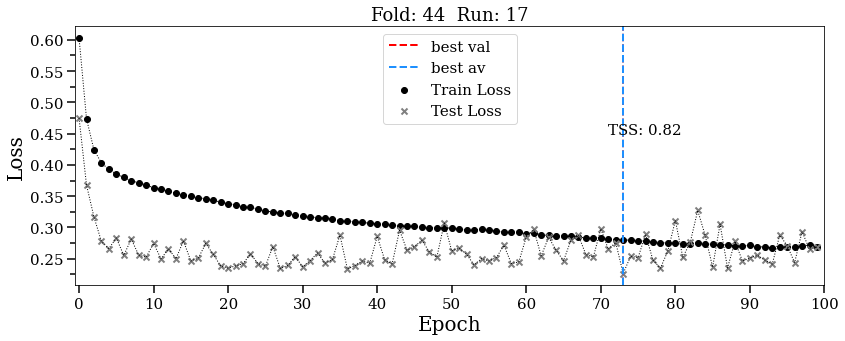

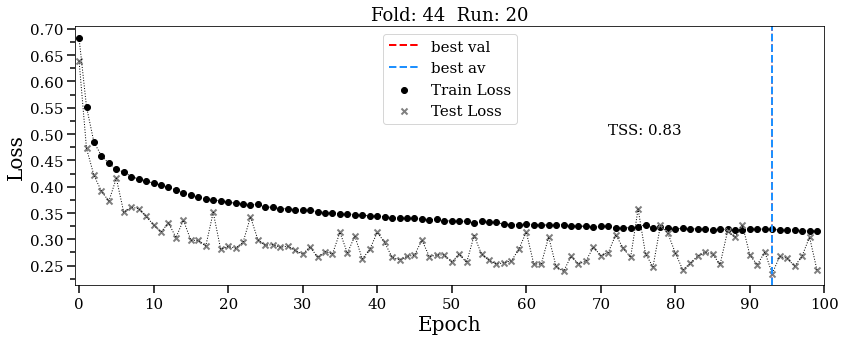

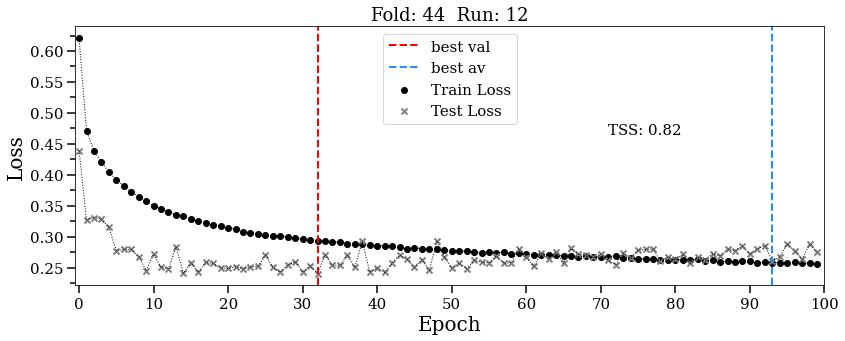

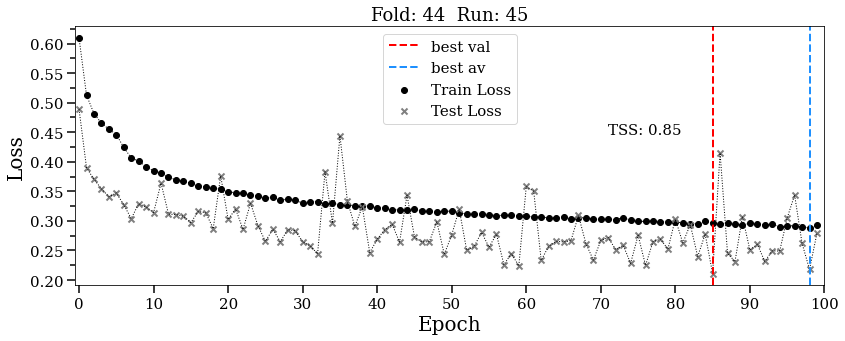

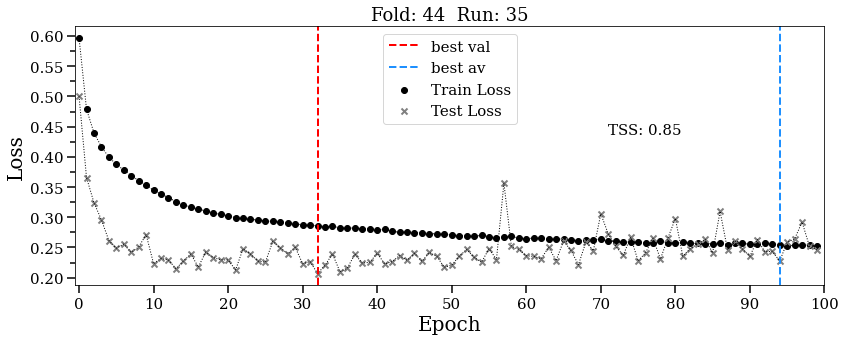

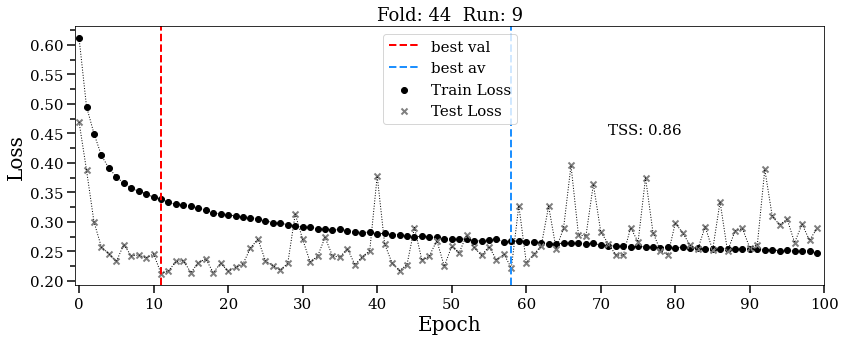

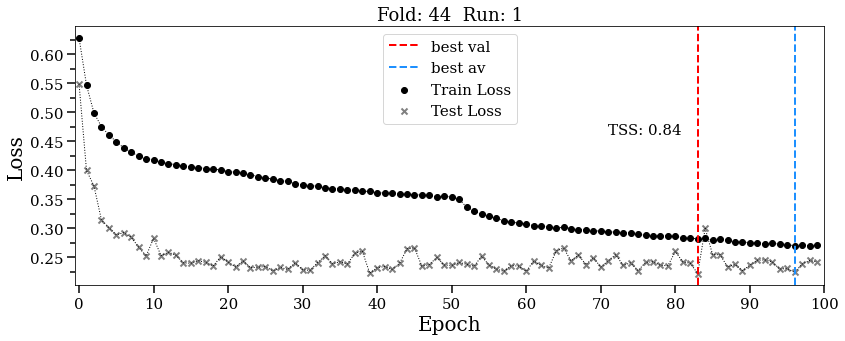

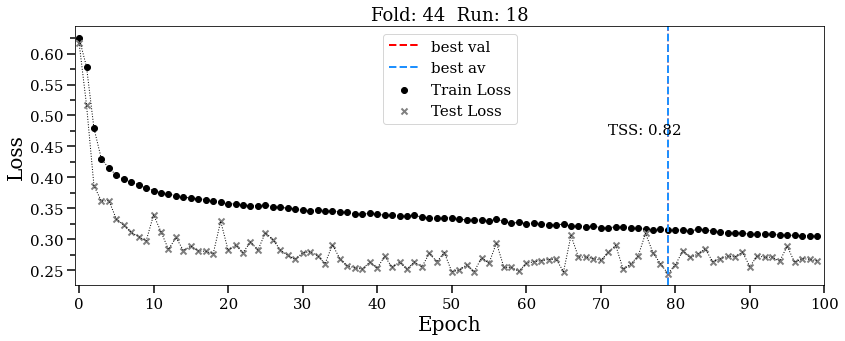

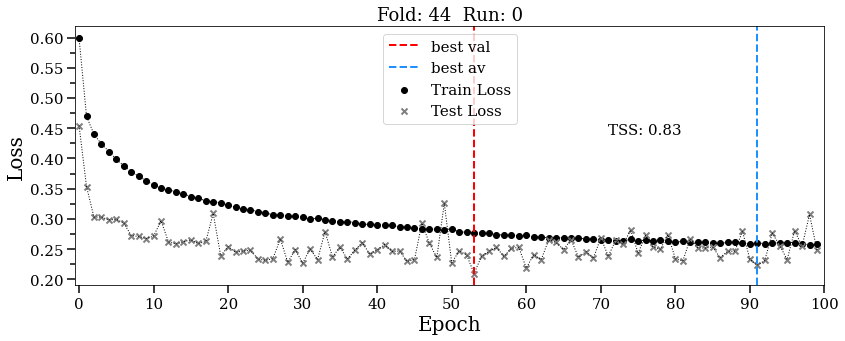

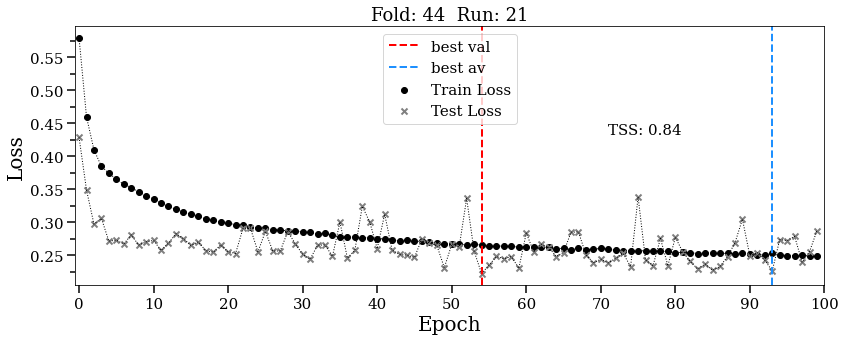

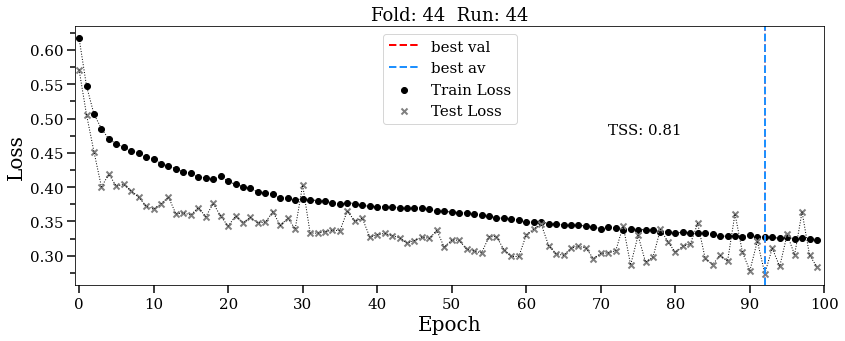

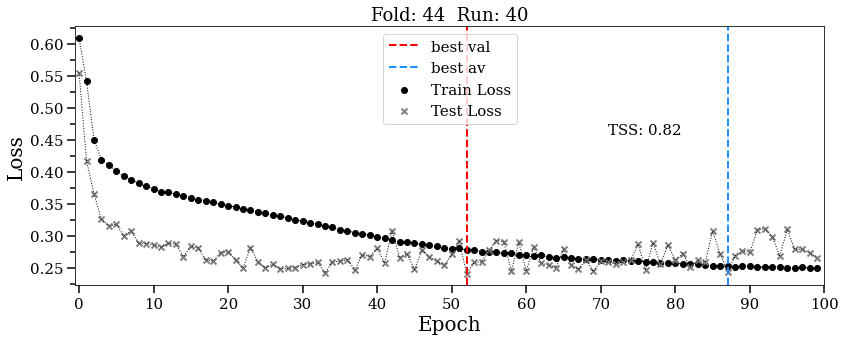

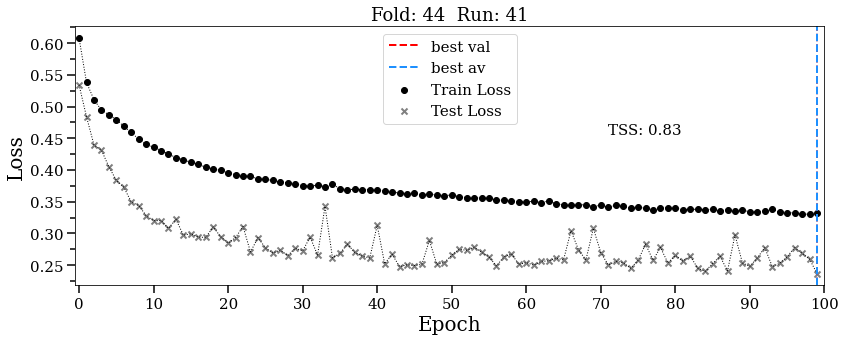

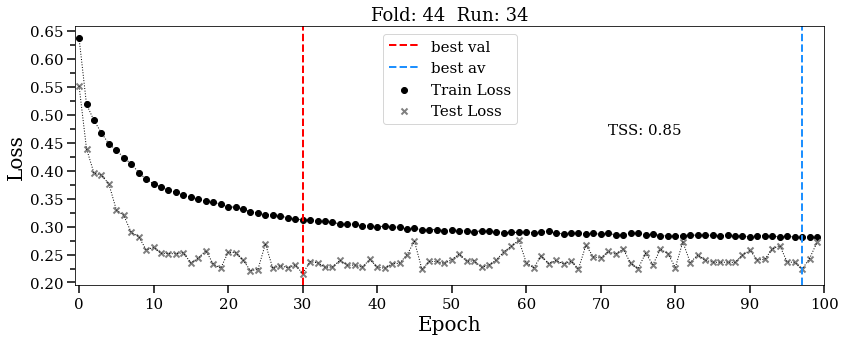

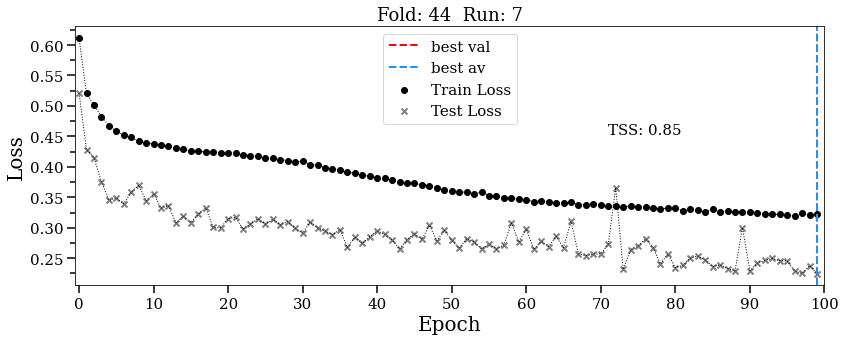

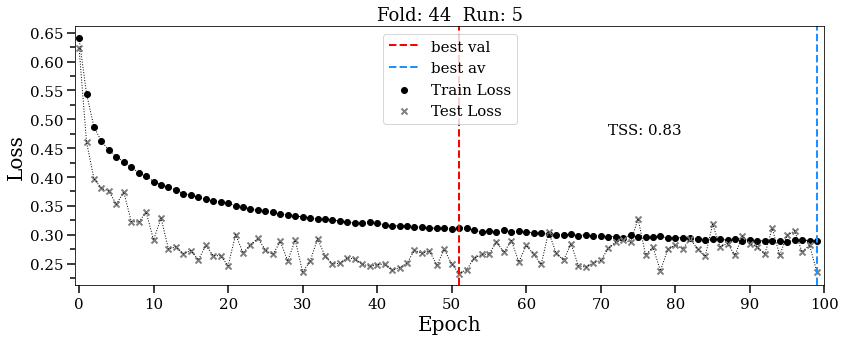

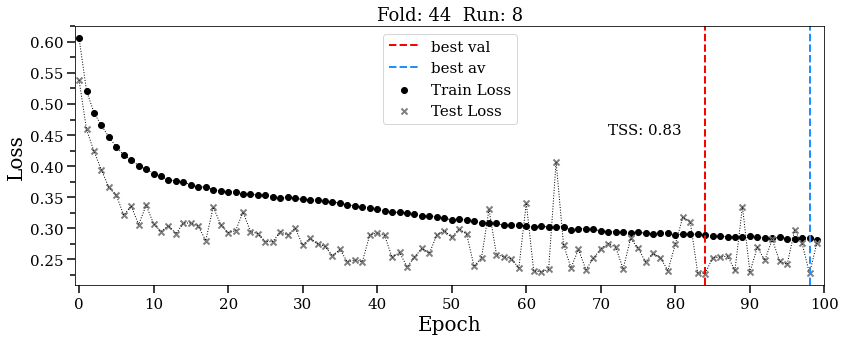

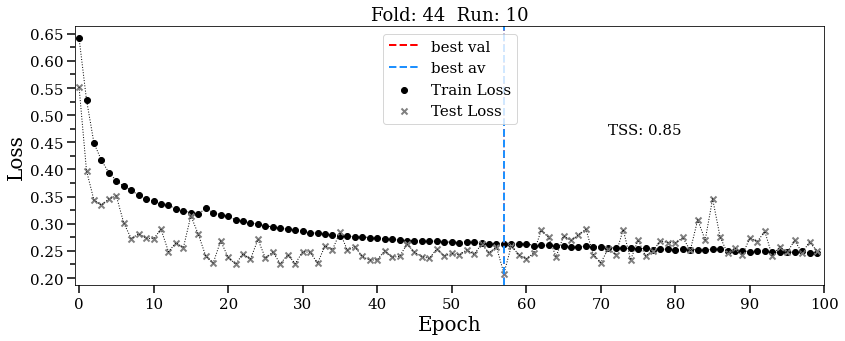

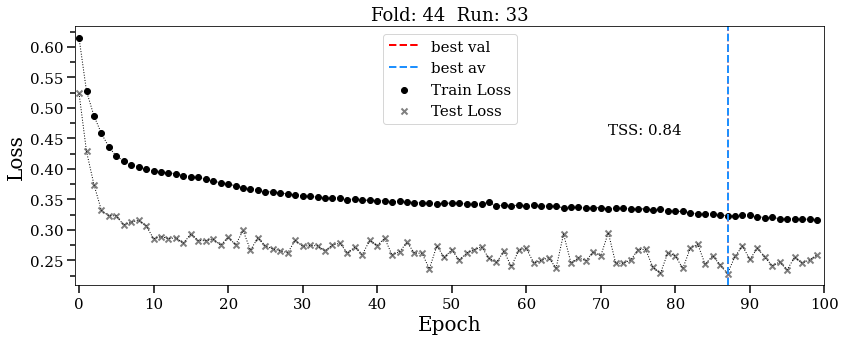

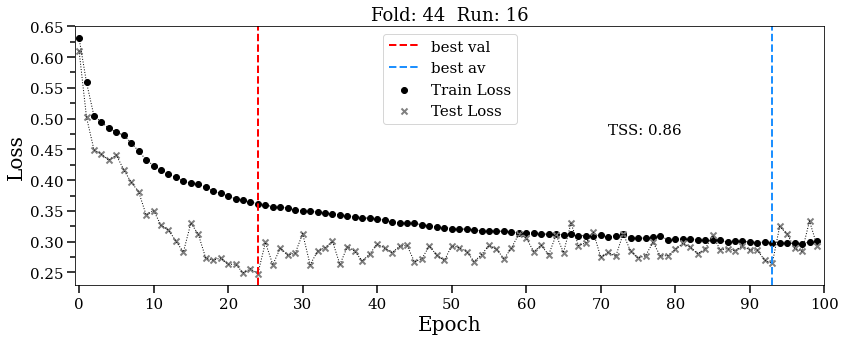

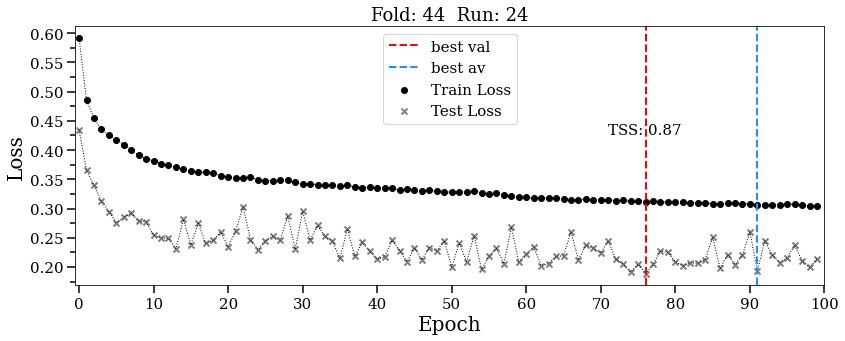

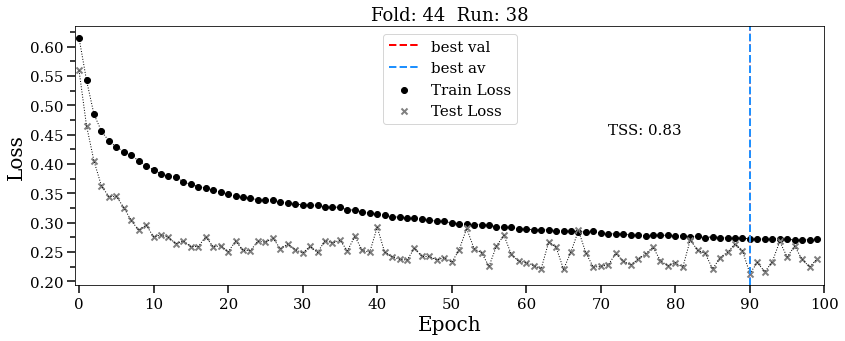

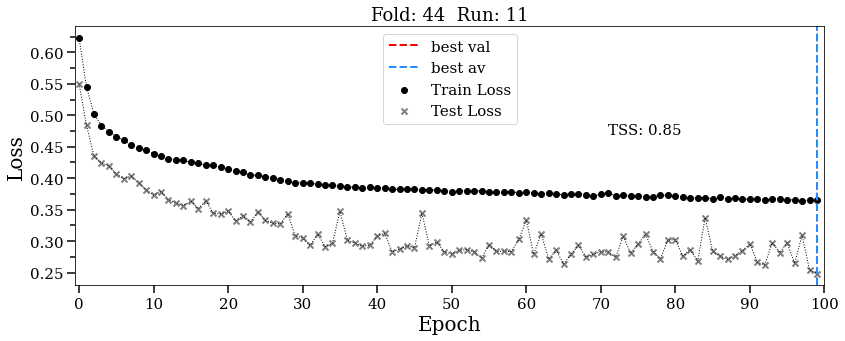

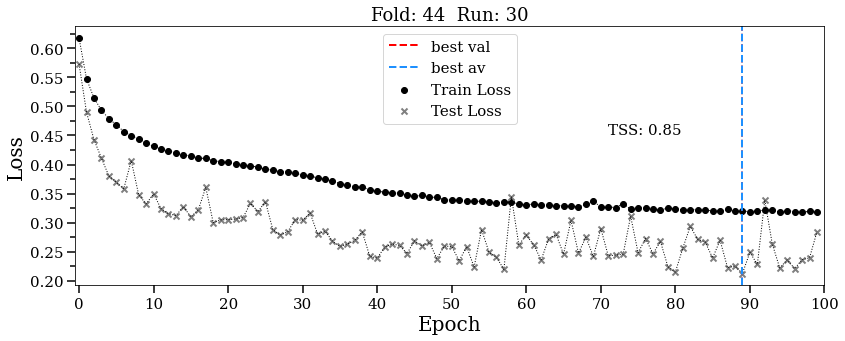

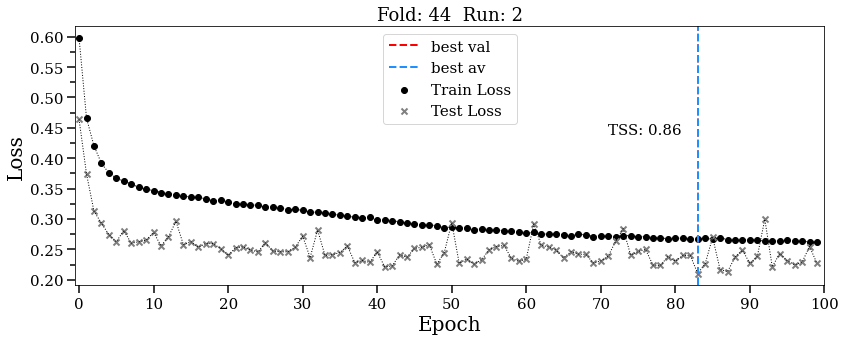

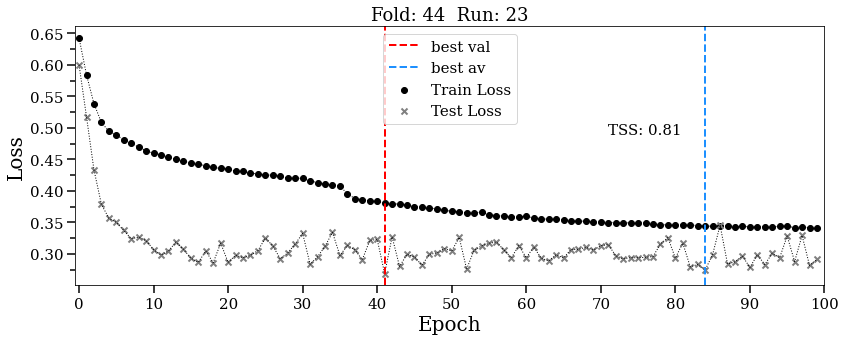

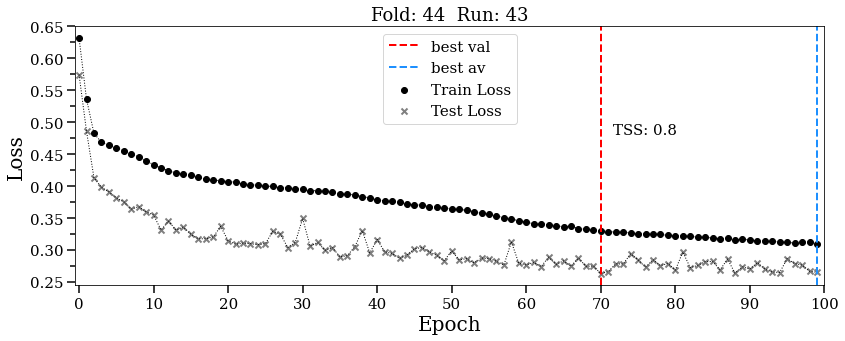

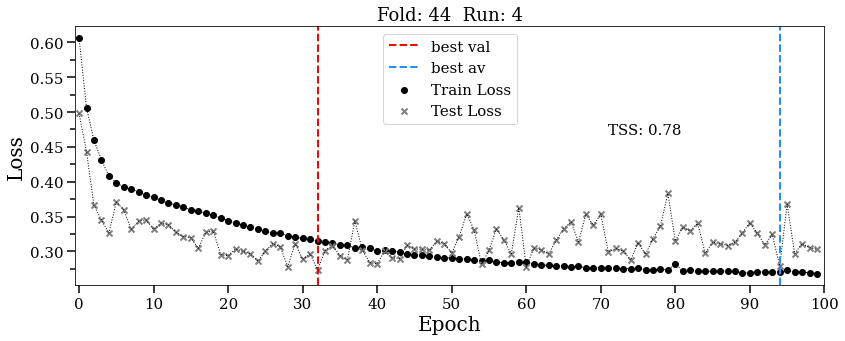

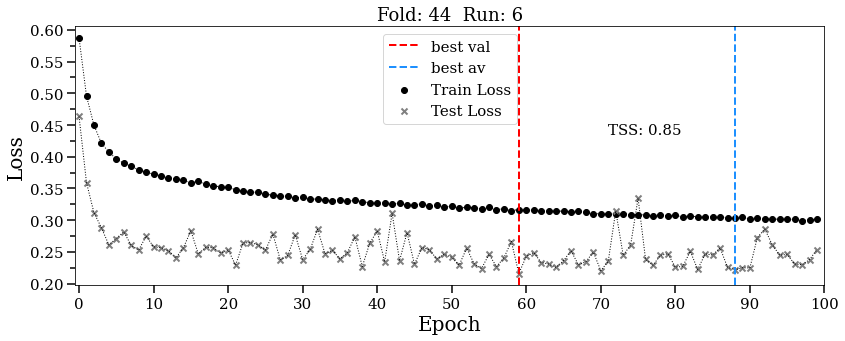

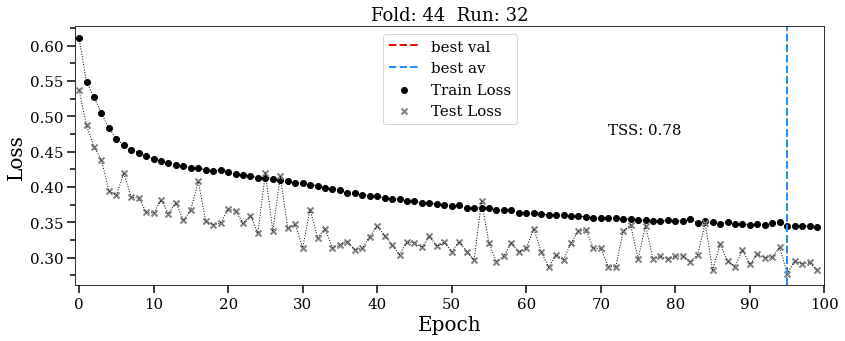

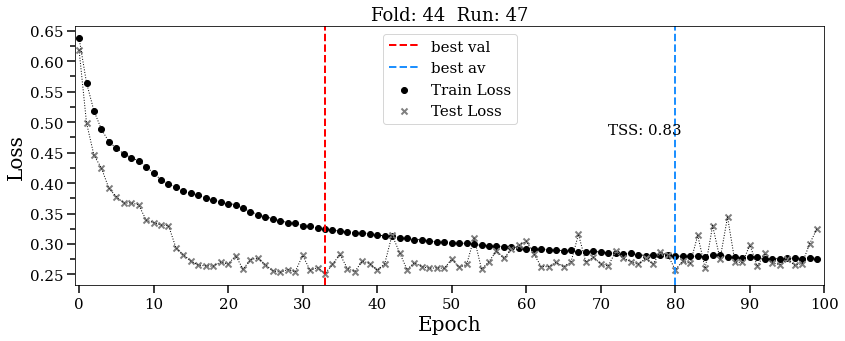

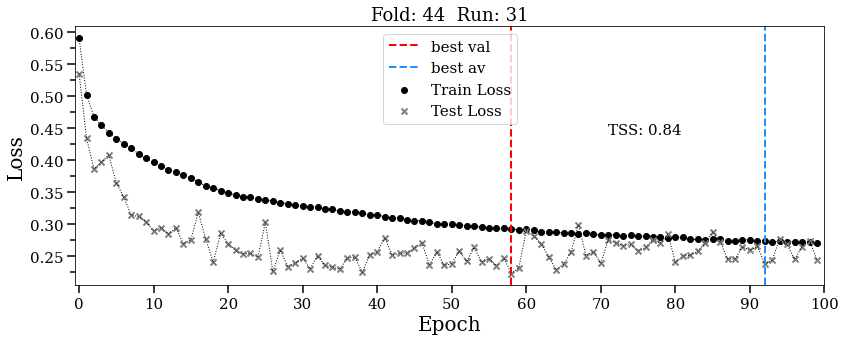

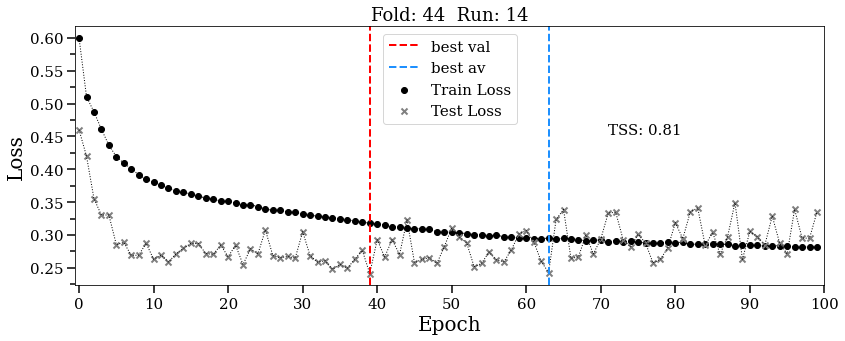

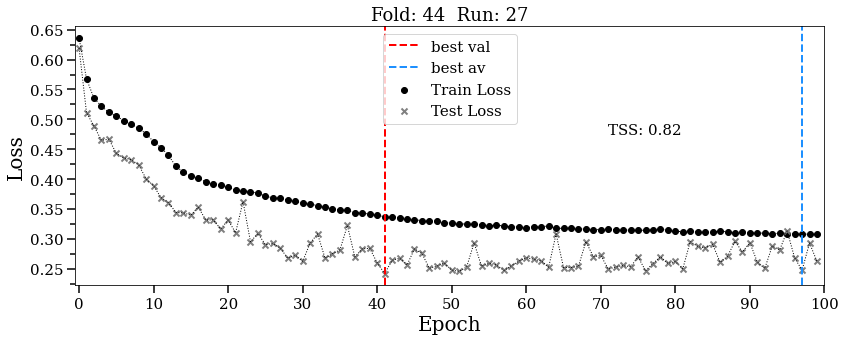

In [3]:
fold = 44
path_to_models = f'/data1/userspace/bpanos/XAI/models/ensembl2/{fold}/' 
all_model_names = os.listdir(path_to_models)
model_names = [ name for name in all_model_names if 'pt' not in name ]
model_paths = [ path_to_models + name for name in model_names ]

for path in model_paths:
    run = path.split('/')[-1][:-2]
    with open(path, 'rb') as f: stats = pickle.load(f)
    fig, ax = plt.subplots(figsize=(12,5))
    rcParams['font.size'] = 15
    rcParams['font.family'] = 'serif'
    plt.rcParams['lines.linewidth'] = 2
    plt.xlabel('Epoch', fontsize=20)
    plt.ylabel('Loss', fontsize=20)
    plt.title(f'Fold: {fold}  Run: {run}')
    tss = stats['TSS']
    plt.text(0.76, 0.6, f'TSS: {tss}', horizontalalignment='center',
                            verticalalignment='center', transform=ax.transAxes)

    train_loss = stats['train_loss_list']
    test_loss = stats['validation_loss_list']
    plt.scatter(range(len(train_loss)), train_loss, c='k', label='Train Loss')
    plt.plot(train_loss, c='k', linewidth=1, linestyle=':')
    plt.scatter(range(len(test_loss)), test_loss, c='grey', label='Test Loss', marker='x')
    plt.plot(test_loss, c='k', linewidth=1, linestyle=':')
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.yaxis.set_major_locator(MultipleLocator(0.05))
    ax.yaxis.set_minor_locator(MultipleLocator(0.025))
    ax.tick_params(which='major', length=8,width=1.5) 
    ax.tick_params(which='minor', length=5,width=1.5)
    # plt.ylim(0.23,0.65)
    plt.xlim(-0.5,100)
    plt.axvline(stats['epoch'], linestyle='--', c='r', label='best val')
    plt.axvline(stats['best_epoch_av'], linestyle='--', c='dodgerblue', label='best av')
    
    ax.legend(loc='upper center')

    plt.tight_layout()
    plt.show()